# 数据由星巴克提供，用来模拟他们的顾客和交易，看看是否有更好的方法来向顾客发送特定的促销优惠

### 原始数据
portfolio.csv - 发送给顾客的优惠数据（10个优惠; 6列）  
profile.csv - 客户的人口统计学数据（17,000名客户; 5列）  
transcript.csv - 客户对报价和交易的反应（306,648个事件; 4列）

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

import string

import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

# 1. 数据导入

In [2]:
data_portfolio = pd.read_csv('Starbucks Customer Segmentation/portfolio.csv', index_col=0)
data_profile= pd.read_csv('Starbucks Customer Segmentation/profile.csv', index_col=0)
data_transcript = pd.read_csv('Starbucks Customer Segmentation/transcript.csv', index_col=0)

## 1.1 数据集初步观察
这个项目是关于分析星巴克的促销活动对客户交易数据的影响，并以此来确定不同客户群体的定位，提高客户粘性和品牌认知，进而增加总体收入。

In [3]:
data_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
data_profile

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
data_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## 1.2 数据集初步结论
1. 本次活动，星巴克一共推出了十种不同的优惠方案；十种方案有不同的推荐渠道、持续时间、奖励、获取难度等
3. 共有17000名客户参与，包含性别、年龄、会员ID、成为会员的日期和收入
3. 活动期间，每位参与者收到的优惠方式和数量均不相同,总共约30W条活动记录

In [6]:
# 对数据集进行 更明显的改名
data_offer = data_portfolio
data_customer = data_profile

## 1.3 初步提出问题
1. 这次活动是否有效？
2. 不同客户群体的活动效益？
3. 有什么改进措施？
4. 特定客户群体的特殊对待？

# 2 数据预处理

## 2.1 检查缺失值

In [7]:
print('data_offer: ' + '\n' + str(data_offer.isnull().sum()))
print('\ndata_customer: ' + '\n' + str(data_customer.isnull().sum()))
print('\ndata_transcript: ' + '\n' + str(data_transcript.isnull().sum()))

data_offer: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

data_customer: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

data_transcript: 
person    0
event     0
value     0
time      0
dtype: int64


In [8]:
# 检查data_customer缺失值的具体情况
data_customer[data_customer['gender'].isnull()]

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,NaN,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,NaN,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,NaN,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,NaN,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


### 通过观察，发现gender和income的缺失值似乎总是一起出现

In [9]:
# 验证两者缺失值之间的关系
missing_num = (data_customer[data_customer['gender'].isnull()]['id'] == data_customer[data_customer['income'].isnull()]['id']).sum()
missing_num

2175

In [10]:
data_customer[data_customer['gender'].isnull()]['age'].value_counts()

age
118    2175
Name: count, dtype: int64

### 验证发现且缺失值的年龄总是为118

In [11]:
# 测算缺失比例
'Missing Number percentage: {:.2%}'.format(missing_num / len(data_customer))

'Missing Number percentage: 12.79%'

## 2.2 处理缺失值

### 根据现有特征，无法较为准确的填充缺失值，为了避免误导数据集结果，直接删除缺失值

In [12]:
removed_id = data_customer[data_customer['gender'].isnull()]['id']

drop_row = data_customer[data_customer['gender'].isnull()].index
data_customer.drop(drop_row, inplace=True)
data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [13]:
# 重置index
data_customer.reset_index()

,index,gender,age,id,became_member_on,income
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...,...
14820,16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
14821,16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
14822,16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
14823,16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### 缺失值处理完毕

## 2.3 数据列的类型检查

In [14]:
data_offer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [15]:
data_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 11.7+ MB


### became_member_on应该属于datetime类型

In [16]:
data_customer['became_member_date'] = pd.to_datetime(data_customer['became_member_on'], format='%Y%m%d')
data_customer.drop('became_member_on', axis=1, inplace=True)

### data_transcript中的time列为自促销活动开始以来的小时数，重命名

In [17]:
data_transcript.rename(columns={'time':'hours_since_start'}, inplace=True)
data_transcript.head()

,person,event,value,hours_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 2.4 数据转换

In [18]:
# data_transcript的value列包含了两个变量
data_transcript['value'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [19]:
# 拆分列
value_column = data_transcript['value']

# 字符串解析为实际的Python字典
value_column = value_column.apply(eval)

# 提取每个字典的键和值,存储在列表中
dictionary_key_column = [list(d.keys())[0] for d in value_column]
dictionary_value_column = [list(d.values())[0] for d in value_column]

value_column_split = pd.DataFrame(columns = ['dict_key', 'dict_value'])

value_column_split['dict_key'] = dictionary_key_column
value_column_split['dict_value'] = dictionary_value_column

value_column_split.head()

,dict_key,dict_value
0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [20]:
data_transcript = data_transcript.drop('value', axis=1)

data_transcript = pd.concat([data_transcript, value_column_split], axis=1)
data_transcript

,person,event,hours_since_start,dict_key,dict_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,amount,3.53


In [21]:
data_offer

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### 为十个不同类型的优惠活动增添一列id，更方便识别

In [22]:
# 按照优惠类型、难易程度、持续时间进行重新排序
data_offer = data_offer.sort_values(['offer_type', 'difficulty', 'duration']).reset_index(drop=True)

# 增添offer_id
column_labels = list(string.ascii_uppercase)[:10]

data_offer['offer_id'] = column_labels
    
data_offer

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,A
1,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,B
2,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,C
3,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,F
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,I
9,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,J


### 数据copy，保存检查点

In [23]:
data_offer2 = data_offer.copy()
data_customer2 = data_customer.copy()
data_transcript2 = data_transcript.copy()

# 3 Exploratory Data Analysis (EDA)

## 3.1 客户特征 -- 单变量统计分析
探索客户的性别、年龄、薪资等对活动的影响

### 3.1.1 性别

In [24]:
data_customer2['gender'].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

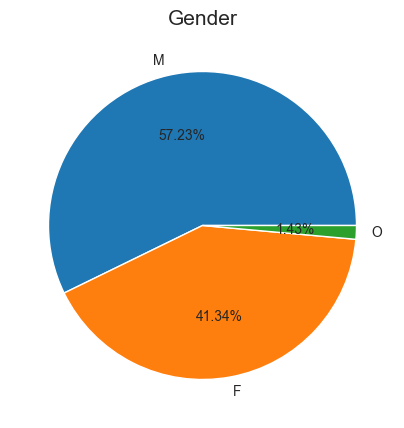

In [25]:
plt.figure(figsize = (5,5))

plt.pie(x=data_customer2['gender'].value_counts(), 
        labels=data_customer2['gender'].value_counts().index.tolist(), 
        autopct = '%1.2f%%')
plt.title('Gender', fontsize=15)

plt.show()

### 性别观察结论：
此次活动中，男性占比57.23%比女性41.34%多

### 3.1.2 年龄

In [26]:
data_customer2['age'].value_counts()

age
58     408
53     372
51     363
59     359
54     359
      ... 
100     12
96       8
98       5
101      5
99       5
Name: count, Length: 84, dtype: int64

In [27]:
data_customer2['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

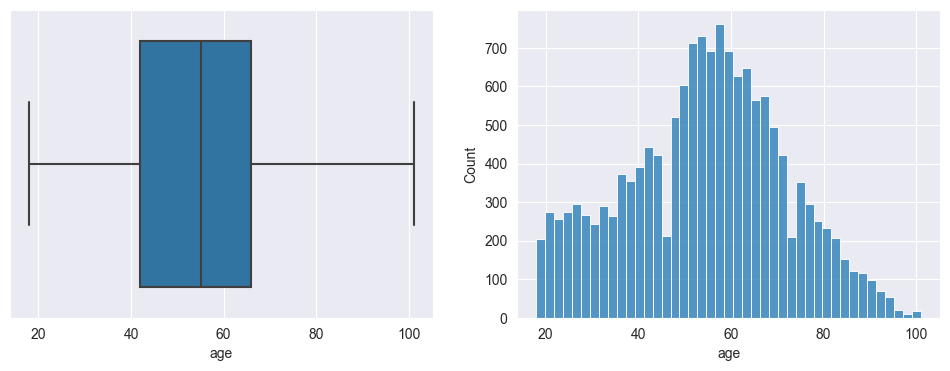

In [28]:
# 年龄可视化
fig, axs = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(data=data_customer2, x='age', ax=axs[0])
sns.histplot(data=data_customer2, x='age', ax=axs[1])

plt.show()

### 年龄数据符合正态分布，但是观察到有异常值

In [29]:
print('Min age: '+ str(min(data_customer2['age'])))
print('Max age: '+ str(max(data_customer2['age'])))

Min age: 18
Max age: 101


In [30]:
# 将年龄进行分组，可视化
age_group = pd.cut(data_customer2['age'],
                  bins = [data_customer2['age'].min(), 26, 36, 46, 56, 66, 76, data_customer2['age'].max()],
                  labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '>76'])

data_customer2['age_group'] = age_group

# 计算各个年龄组的占比
age_group_per = (data_customer2['age_group'].value_counts().sort_index() / data_customer2.shape[0] * 100).round(2)
age_group_per

age_group
18-25     7.41
26-35     9.31
36-45    13.62
46-55    22.00
56-65    22.21
66-75    14.89
>76      10.08
Name: count, dtype: float64

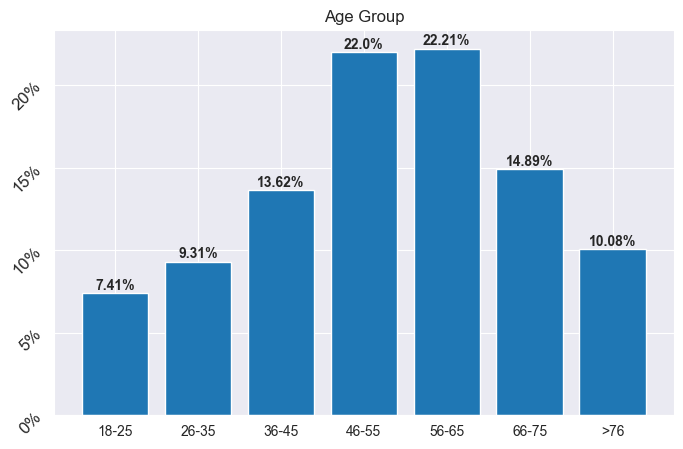

In [31]:
plt.figure(figsize=(8,5))

yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]

plt.yticks(yticks, labels = yticklabels)
plt.yticks(rotation = 45, fontsize = 12)
plt.title('Age Group')

bar_plot = plt.bar(x = age_group_per.index.values, height = age_group_per)

for i, bar in enumerate(bar_plot.patches):
    x,y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_per[i]) + '%',
            ha = 'center',
            weight = 'bold')

### 年龄观察结论：
1. 第一梯队占比最多的年龄组为46-65岁，一共占据约50%，是这次优惠活动反应的主力
2. 第二梯队，年龄组为36-45和66-75，各占14%左右
3. 总体来说，年轻人的占比是最低的，说明他们对优惠活动的反应不大；中老年人对于优惠活动的参与度更高

### 3.1.3 收入分析

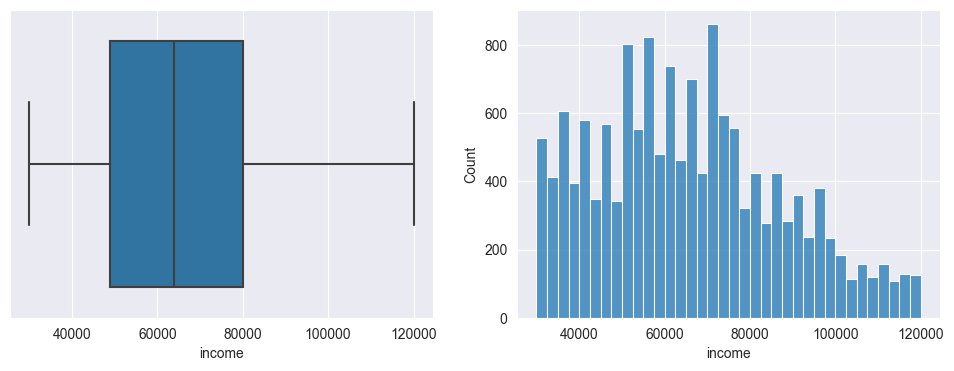

In [32]:
# 同样先观察收入的可视化基本情况
fig, axs = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(data=data_customer2, x='income', ax=axs[0])
sns.histplot(data=data_customer2, x='income', ax=axs[1])

plt.show()

In [33]:
data_customer2['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [34]:
print('收入众数为'+ str(data_customer2['income'].value_counts().tolist()[0])+ 
      '个人, \n收入为' +
      str(data_customer2['income'].mode().values[0]) + '元'
     )

收入众数为314个人, 
收入为73000.0元


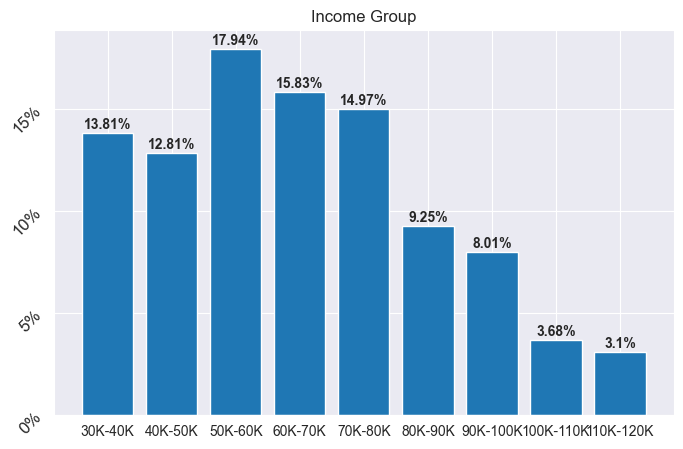

In [35]:
# 收入分组可视化
income_group = pd.cut(data_customer2['income'],
                  bins = [data_customer2['income'].min(), 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, data_customer2['income'].max()],
                  labels = ['30K-40K', '40K-50K', '50K-60K', '60K-70K', '70K-80K', '80K-90K', '90K-100K', '100K-110K', '110K-120K'])

data_customer2['income_group'] = income_group

# 计算各个年龄组的占比
income_group_per = (data_customer2['income_group'].value_counts().sort_index() / data_customer2.shape[0] * 100).round(2)


# 可视化
plt.figure(figsize=(8,5))

yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]

plt.yticks(yticks, labels = yticklabels)
plt.yticks(rotation = 45, fontsize = 12)
plt.title('Income Group')

bar_plot = plt.bar(x = income_group_per.index.values, height = income_group_per)

for i, bar in enumerate(bar_plot.patches):
    x,y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(income_group_per[i]) + '%',
            ha = 'center',
            weight = 'bold')

### 收入观察结果：
1. 客户收入范围在30K-120K，平均为65K
2. 收入极高的人对优惠活动的响应较低
3. 合理推测，收入极低或极高的人，都不是优惠活动的目标客群

### 3.1.4 成为会员时间的影响分析

#### 将时间拆分成年、月、日、工作日等不同维度，便于后续分析

In [36]:
data_customer2 = data_customer2.assign(member_year = data_customer2.became_member_date.dt.year,
                                      member_month = data_customer2.became_member_date.dt.month,
                                      member_day = data_customer2.became_member_date.dt.day,
                                      member_day_of_week = data_customer2.became_member_date.dt.weekday,
                                      member_day_name = data_customer2.became_member_date.dt.day_name())

data_customer2

,gender,age,id,income,became_member_date,age_group,income_group,member_year,member_month,member_day,member_day_of_week,member_day_name
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,66-75,90K-100K,2017,5,9,1,Tuesday
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,66-75,60K-70K,2018,4,26,3,Thursday
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,56-65,50K-60K,2018,2,9,4,Friday
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,56-65,50K-60K,2017,11,11,5,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018-06-04,36-45,50K-60K,2018,6,4,0,Monday
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018-07-13,56-65,70K-80K,2018,7,13,4,Friday
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017-01-26,46-55,70K-80K,2017,1,26,3,Thursday
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016-03-07,>76,40K-50K,2016,3,7,0,Monday


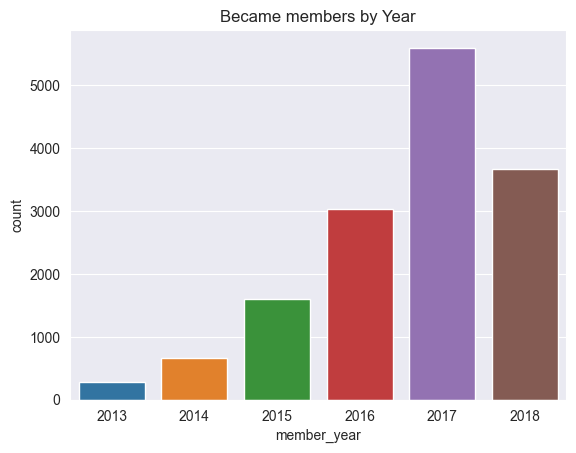

In [37]:
# 对"年"进行可视化分析
sns.countplot(data = data_customer2, x = 'member_year')
plt.title('Became members by Year')

counts = data_customer2.groupby('member_year')['id'].nunique()  

plt.show()

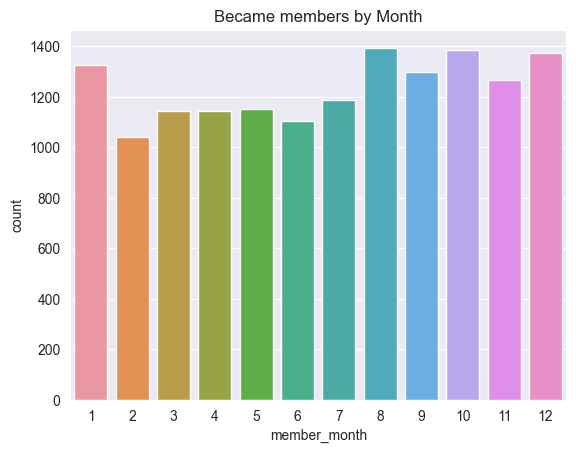

In [38]:
# 对"月"进行可视化分析
sns.countplot(data = data_customer2, x = 'member_month')

plt.title('Became members by Month')

plt.show()

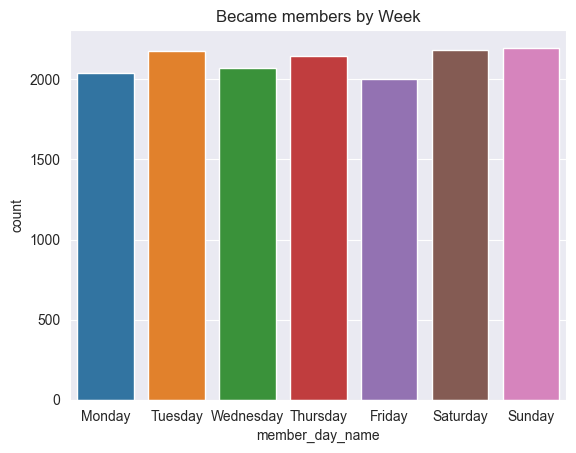

In [39]:
# 对"周"进行可视化分析
sns.countplot(data = data_customer2.sort_values('member_day_of_week'), x = 'member_day_name')

plt.title('Became members by Week')

plt.show()

### 成为会员时间的观察结果：
1. 年：从2013-2017逐年增长，2017增长迅猛，但2018骤降。具体原因需要进一步分析，如使用PEST行业分析、多维度拆解分析等方法进行深入分析
2. 2-7月份新会员数量增长较少，8-1月份数量增长较多，可能与季节相关，得根据活动当地的实际情况进行分析
3. 工作日和周中的会员注册人数更高，猜测和目标客群多为需要工作的人居多有关。可考虑在周末增加活动力度，吸引新会员

## 3.2 对客户进行特征探索 -- 双变量解析 (Bivariate analysis)

## 3.2.1 年龄 - 性别

In [41]:
data_customer2.groupby('gender').agg({'age':'mean'})

,age
gender,
F,57.544950
M,52.116690
O,54.400943


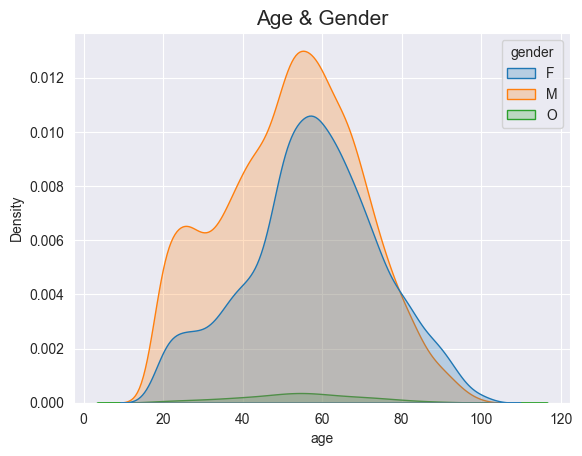

In [42]:
sns.kdeplot(data = data_customer2, x = 'age', hue = 'gender', fill = True)
plt.title('Age & Gender', fontsize = 15)

plt.show()

### 年龄 - 性别
1. 女性顾客较为符合正态分布
2. 男性顾客偏向年轻化

## 3.2.2 收入 - 性别

In [43]:
data_customer2.groupby('gender').agg({'income':'mean'})

,income
gender,
F,71306.412139
M,61194.601603
O,63287.735849


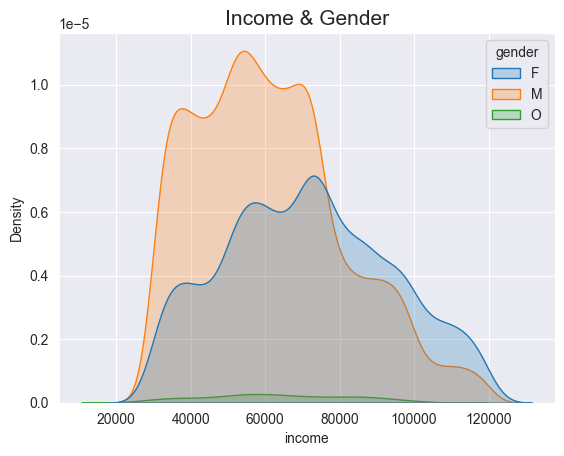

In [44]:
sns.kdeplot(data = data_customer2, x = 'income', hue = 'gender', fill = True)
plt.title('Income & Gender', fontsize = 15)

plt.show()

### 收入 - 性别
1. 在40K-70K这一收入范围，男性顾客远多于女性顾客
2. 女性顾客的收入差异更大
3. 在高收入的顾客群体中，男女收入分布差异不太大

## 3.2.3 年龄 - 收入

In [47]:
data_customer2.groupby('age_group').agg({'income':'mean'})

,income
age_group,
18-25,50924.476797
26-35,51168.840580
36-45,59424.467558
46-55,69203.862661
56-65,70026.116004
66-75,70690.530131
>76,71707.692308


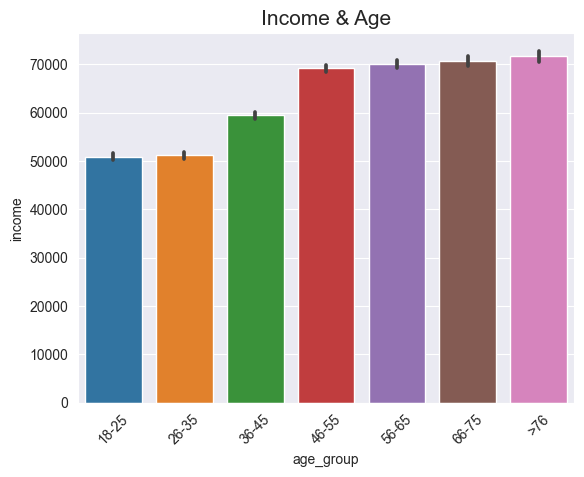

In [48]:
sns.barplot(data = data_customer2, x = 'age_group', y = 'income')

plt.xticks(rotation = 45)

plt.title('Income & Age', fontsize = 15)

plt.show()

<Axes: >

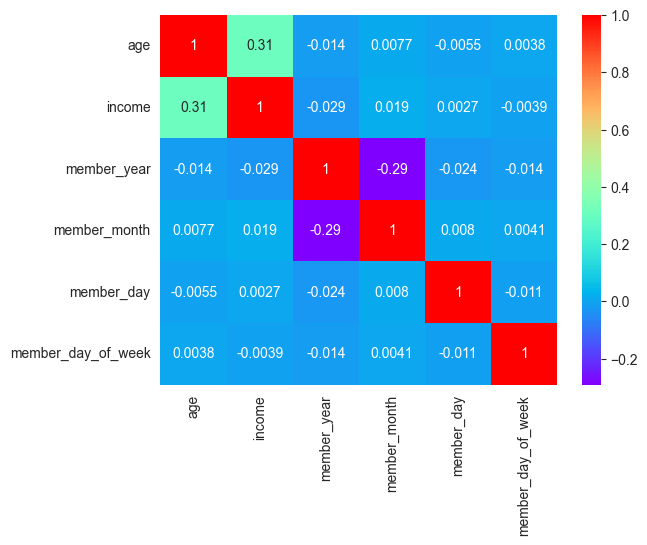

In [49]:
customer_related = data_customer2.select_dtypes(np.number)

sns.heatmap(customer_related.corr(), annot=True, cmap='rainbow')

### 年龄 - 收入
1. 年龄与收入呈正相关.年龄越大，收入越高

## 3.3 对商家活动进行特征探索

In [50]:
data_offer2

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,A
1,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,B
2,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,C
3,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,F
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,I
9,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,J


In [51]:
data_offer2['offer_type'].value_counts()

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

### 共10个不同的活动，包含3个数值型特征和3个非数值型特征

## 3.3.1 活动类型

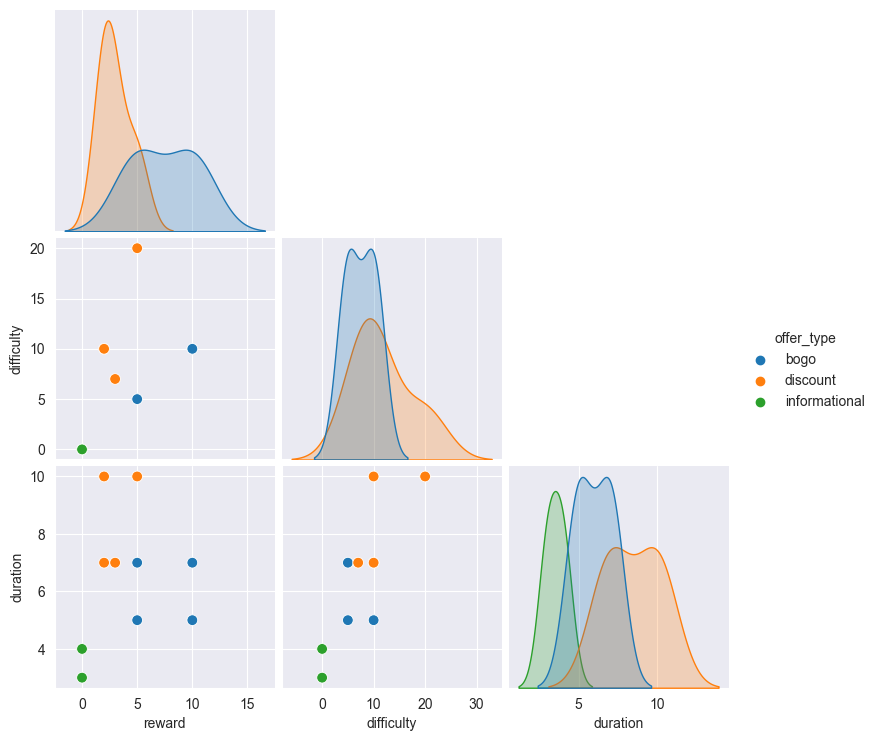

In [55]:
# 绘制散点图矩阵 分层核密度估计 (KDE)
sns.pairplot(data_offer2, hue='offer_type',
            plot_kws = dict(marker='o', s=60),
            corner=True)
plt.show()

### 折扣优惠持续时间最长，同时难度也是最高的，但是奖励较低

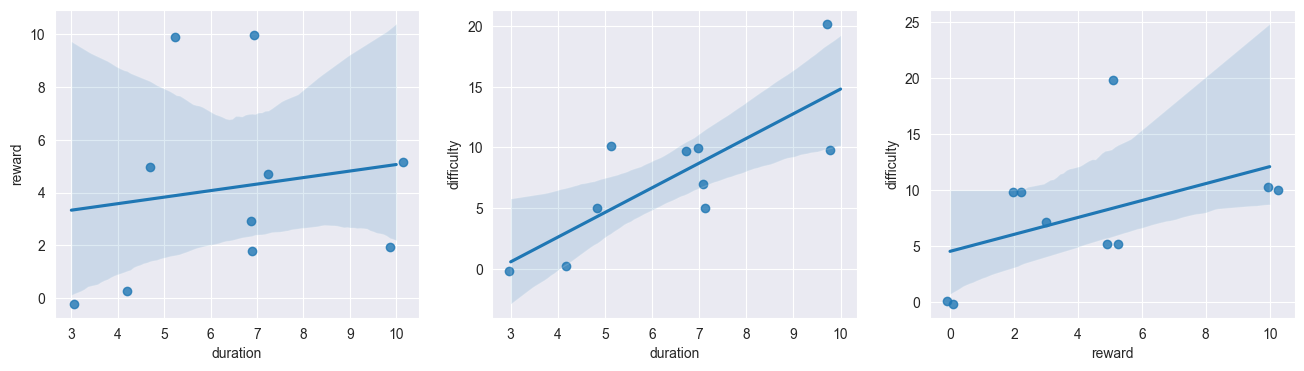

In [56]:
# 进一步分析相关性
fig, axs = plt.subplots(1,3, figsize = (16,4))

sns.regplot(data = data_offer2, x = 'duration', y ='reward', x_jitter = 0.3, y_jitter = 0.3, ax = axs[0])
sns.regplot(data = data_offer2, x = 'duration', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[1])
sns.regplot(data = data_offer2, x = 'reward', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[2])

plt.show()

### 活动类型
1. 持续时间和难度存在一定的正相关关系

### 活动推送途径

In [57]:
data_offer2['channels'].value_counts()

channels
['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['email', 'mobile', 'social']           2
['web', 'email']                        1
Name: count, dtype: int64

## 综上所述，活动：
1. 共10个不同的活动类型
2. 4个'bogo'买一送一优惠，4个'折扣'优惠，2个'信息'优惠
3. 总共四张不同推送途径，'web', 'email', 'mobile', 'social'，重新组成四种不同组合
4. 活动中持续时间和困难呈正相关

## 3.3.2 对活动情况进行特征探索

In [58]:
data_transcript2

,person,event,hours_since_start,dict_key,dict_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,amount,3.53


In [59]:
data_transcript2['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

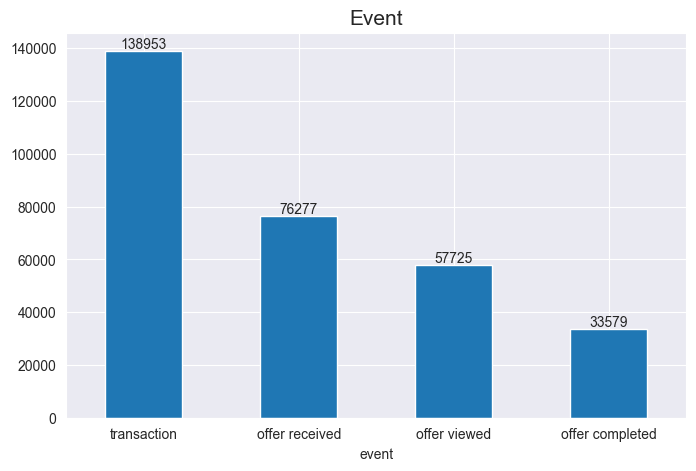

In [60]:
plt.figure(figsize = (8,5))

data_transcript2['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title('Event', fontsize=15)

# 添加数值显示
counts = data_transcript2['event'].value_counts()  
ax = plt.gca()
heights = [rect.get_height() for rect in ax.patches]  

for rect, h, c in zip(ax.patches, heights, counts): 
    ax.text(rect.get_x() + rect.get_width() / 2, h + 0.5, c,
            ha='center', va='bottom', fontsize=10)

plt.show()

In [78]:
data_transcript2['event'].value_counts().to_dict()

{'transaction': 138953,
 'offer received': 76277,
 'offer viewed': 57725,
 'offer completed': 33579}

In [86]:
activity_stat = data_transcript2['event'].value_counts().to_dict()

print('交易总量：' + str(activity_stat['transaction']))
print('浏览率：' + str(round((activity_stat['offer viewed'] / activity_stat['offer received']), 2)))
print('完成率：' + str(round((activity_stat['offer completed'] / activity_stat['offer received']), 2)))
print('优惠活动交易占比：' + str(round((activity_stat['offer completed'] / activity_stat['transaction']), 2)))

交易总量：138953
浏览率：0.76
完成率：0.44
优惠活动交易占比：0.24


### 活动效果
1. 活动期间，交易总量：138953。
2. 76%的顾客浏览率，证明营销活动的设计很成功，吸引了绝大部分客户的参与
3. 44%的顾客完成了优惠活动交易
4. 优惠活动期间，使用了优惠的交易占比24%，说明很多客户即使没有优惠也在进行交易，体现良好的客户粘性

## 3.3.3 活动随事件变化的特征探索

In [89]:
# 新建特征列，代表活动进行的第几天
data_transcript2 = data_transcript2.assign(day_since_start = data_transcript2['hours_since_start'] / 24).astype({'day_since_start':'int64'})
data_transcript2

,person,event,hours_since_start,dict_key,dict_value,day_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,amount,1.59,29
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,amount,9.53,29
306531,a00058cf10334a308c68e7631c529907,transaction,714,amount,3.61,29
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,amount,3.53,29


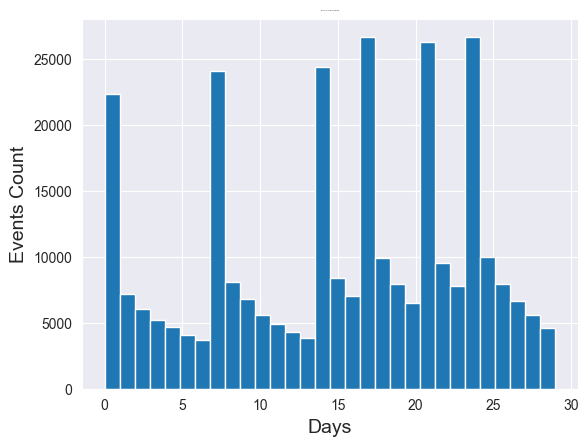

In [90]:
# 可视化活动随着时间变化的特征变化
plt.hist(data_transcript2['day_since_start'], bins = 30)

plt.xlabel('Days', fontsize = 14)
plt.ylabel('Events Count', fontsize = 14)
plt.title('Events Occurrence over time', fontsize = 1)

plt.show()

### 活动时间
1. 整个活动持续时间内，有明显6个事件高峰，对应六个特征类似的数值变化
2. 猜测活动期间共有六次活动推送，顾客随后发生了查看、消费、购买等活动

In [92]:
# 寻找活动推送的时间节点
data_transcript2[data_transcript2['event'] == 'offer received'].groupby('hours_since_start').count()

,person,event,dict_key,dict_value,day_since_start
hours_since_start,,,,,
0,12650,12650,12650,12650,12650
168,12669,12669,12669,12669,12669
336,12711,12711,12711,12711,12711
408,12778,12778,12778,12778,12778
504,12704,12704,12704,12704,12704
576,12765,12765,12765,12765,12765


In [93]:
data_transcript2[data_transcript2['event'] == 'offer received'].groupby('day_since_start').count()

,person,event,hours_since_start,dict_key,dict_value
day_since_start,,,,,
0,12650,12650,12650,12650,12650
7,12669,12669,12669,12669,12669
14,12711,12711,12711,12711,12711
17,12778,12778,12778,12778,12778
21,12704,12704,12704,12704,12704
24,12765,12765,12765,12765,12765


### 活动推送时间
1. 集中推送
2. 才开始间隔约一周，活动后期每三天推送一次

In [96]:
# 计算客户三种活动的时间 -- 单位：小时
viewed_hourly = data_transcript2[data_transcript2['event'] == 'offer viewed'].value_counts('hours_since_start').sort_index()
completed_hourly = data_transcript2[data_transcript2['event'] == 'offer completed'].value_counts('hours_since_start').sort_index()
transaction_hourly = data_transcript2[data_transcript2['event'] == 'transaction'].value_counts('hours_since_start').sort_index()
print(len(viewed_hourly), len(completed_hourly), len(transaction_hourly))

120 120 120


In [97]:
# 计算客户三种活动的时间 -- 单位：天
viewed_daily = data_transcript2[data_transcript2['event'] == 'offer viewed'].value_counts('day_since_start').sort_index()
completed_daily = data_transcript2[data_transcript2['event'] == 'offer completed'].value_counts('day_since_start').sort_index()
transaction_daily = data_transcript2[data_transcript2['event'] == 'transaction'].value_counts('day_since_start').sort_index()
print(len(viewed_daily), len(completed_daily), len(transaction_daily))

30 30 30


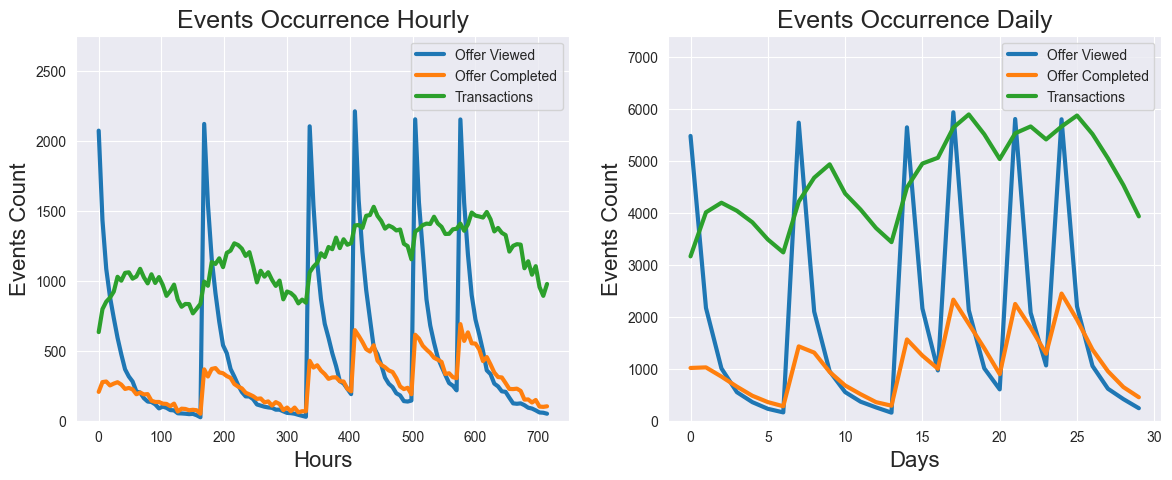

In [98]:
# 客户行为特征随着活动发生时间变化，可视化
hours = viewed_hourly.index.values

fig, axs = plt.subplots(1,2, figsize = (14, 5))

axs[0].plot(hours, viewed_hourly, lw = 3)
axs[0].plot(hours, completed_hourly, lw = 3)
axs[0].plot(hours, transaction_hourly, lw = 3)

axs[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)

axs[0].set_ylim([0, 2750])

axs[0].set_xlabel('Hours', fontsize = 16)
axs[0].set_ylabel('Events Count', fontsize = 16)
axs[0].set_title('Events Occurrence Hourly', fontsize = 18)



days = np.arange(30)

axs[1].plot(days, viewed_daily, lw = 3)
axs[1].plot(days, completed_daily, lw = 3)
axs[1].plot(days, transaction_daily, lw = 3)

axs[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)

axs[1].set_ylim([0, 7400])

axs[1].set_xlabel('Days', fontsize = 16)
axs[1].set_ylabel('Events Count', fontsize = 16)
axs[1].set_title('Events Occurrence Daily', fontsize = 18)

plt.show()

## 综上所述，活动情况：
1. 整个活动持续时间一个月
2. 共计主动推送了六次，前三次间隔约一周，后三次每三天推送，且推送时间都在一小时内完成
3. 每次推送之后，客户都会被唤醒，达到接收查看活动信息高峰，紧接着几小时内，达到活动使用消费高峰，证明大部分客户在接收优惠活动后当天便会使用
4. 活动期间的客户参与数量和交易数量均良好，且随着时间推移，交易量逐渐上升，证明此次活动设计很成功
5. 优惠活动不仅能带来短期消费的增加，而且提高了客户粘性，助于客户形成消费习惯；所以公司可以尝试以一定的频率对客户发送优惠

# 4. 数据预处理

In [107]:
customer_event = pd.merge(data_customer2, data_transcript, left_on='id', right_on='person')
customer_event

,gender,age,id,income,became_member_date,age_group,income_group,member_year,member_month,member_day,member_day_of_week,member_day_name,person,event,hours_since_start,dict_key,dict_value
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday,0610b486422d4921ae7d2bf64640c50b,transaction,18,amount,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday,0610b486422d4921ae7d2bf64640c50b,transaction,144,amount,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday,0610b486422d4921ae7d2bf64640c50b,offer received,408,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday,0610b486422d4921ae7d2bf64640c50b,offer received,504,offer id,3f207df678b143eea3cee63160fa8bed
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,46-55,110K-120K,2017,7,15,5,Saturday,0610b486422d4921ae7d2bf64640c50b,transaction,528,amount,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017-07-22,56-65,80K-90K,2017,7,22,5,Saturday,e4052622e5ba45a8b96b59aba68cf068,offer completed,480,offer_id,f19421c1d4aa40978ebb69ca19b0e20d
272758,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017-07-22,56-65,80K-90K,2017,7,22,5,Saturday,e4052622e5ba45a8b96b59aba68cf068,transaction,486,amount,19.47
272759,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017-07-22,56-65,80K-90K,2017,7,22,5,Saturday,e4052622e5ba45a8b96b59aba68cf068,offer viewed,546,offer id,f19421c1d4aa40978ebb69ca19b0e20d
272760,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017-07-22,56-65,80K-90K,2017,7,22,5,Saturday,e4052622e5ba45a8b96b59aba68cf068,offer received,576,offer id,3f207df678b143eea3cee63160fa8bed


### 提取与客户特征相关的信息，包括客户、收到的优惠数量、查看的优惠数量、完成的优惠数量、交易数量、交易总额

In [222]:
# 创建新的表格
customer_behavior = pd.DataFrame()

In [223]:
# 添加person主列
customer_behavior['person'] = customer_event['id']

# 添加客户特征列
customer_behavior[['person', 'age', 'gender', 'income']] = customer_event[['id', 'age', 'gender', 'income']]

In [224]:
# num_received
df_num_received = customer_event[
                        customer_event['event'] == 'offer received'].groupby('id').size().reset_index(name='num_received')

customer_behavior = pd.merge(
                        customer_behavior, df_num_received[['id', 'num_received']].set_index('id'), left_on='person', right_index=True)



# num_viewed
df_num_viewed = customer_event[
                        customer_event['event'] == 'offer viewed'].groupby('id').size().reset_index(name='num_viewed')

customer_behavior = pd.merge(
                        customer_behavior, df_num_viewed[['id', 'num_viewed']].set_index('id'), left_on='person', right_index=True)

# num_completed
df_num_completed = customer_event[
                        customer_event['event'] == 'offer completed'].groupby('id').size().reset_index(name='num_completed')

customer_behavior = pd.merge(
                        customer_behavior, df_num_completed[['id', 'num_completed']].set_index('id'), left_on='person', right_index=True)

# num_transactions
df_num_transactions = customer_event[
                        customer_event['event'] == 'transaction'].groupby('id').size().reset_index(name='num_transactions')

customer_behavior = pd.merge(
                        customer_behavior, df_num_transactions[['id', 'num_transactions']].set_index('id'), left_on='person', right_index=True)


In [225]:
# money_spent
df_money_spent = customer_event[
                        customer_event['dict_key'] == 'amount'].groupby('id')['dict_value'].sum().reset_index(name='money_spent')

customer_behavior = pd.merge(
                        customer_behavior, df_money_spent[['id', 'money_spent']].set_index('id'), left_on='person', right_index=True, how='inner')

# 去重
customer_behavior = customer_behavior.drop_duplicates().reset_index()
customer_behavior

,index,person,age,gender,income,num_received,num_viewed,num_completed,num_transactions,money_spent
0,6,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,4,4,3,7,159.27
1,24,e2127556f4f64592b11af22de27a7932,68,M,70000.0,4,3,2,3,57.73
2,36,389bc3fa690240e798340f5a15918d5c,65,M,53000.0,6,6,5,3,36.43
3,56,2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,3,2,1,4,15.62
4,66,aa4862eba776480b8bb9c68455b8c2e1,61,F,57000.0,5,5,3,6,85.55
...,...,...,...,...,...,...,...,...,...,...
11911,272617,f653cf2d8bba42d0a53c2937ee2e5893,64,M,51000.0,5,3,3,9,32.44
11912,272637,79edb810789c447e8d212a324b44cc16,70,F,39000.0,5,5,4,15,143.75
11913,272701,2cb4f97358b841b9a9773a7aa05a9d77,61,M,72000.0,3,1,1,7,25.97
11914,272725,9dc1421481194dcd9400aec7c9ae6366,83,F,50000.0,3,3,3,14,189.67


In [226]:
# 将gender列转化为数值列
customer_behavior['gender'].replace({'F': 0, 'M': 1, 'O': 2}, inplace=True)

In [227]:
customer_behavior.drop('index', axis=1, inplace=True)
customer_behavior

,person,age,gender,income,num_received,num_viewed,num_completed,num_transactions,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,4,4,3,7,159.27
1,e2127556f4f64592b11af22de27a7932,68,1,70000.0,4,3,2,3,57.73
2,389bc3fa690240e798340f5a15918d5c,65,1,53000.0,6,6,5,3,36.43
3,2eeac8d8feae4a8cad5a6af0499a211d,58,1,51000.0,3,2,1,4,15.62
4,aa4862eba776480b8bb9c68455b8c2e1,61,0,57000.0,5,5,3,6,85.55
...,...,...,...,...,...,...,...,...,...
11911,f653cf2d8bba42d0a53c2937ee2e5893,64,1,51000.0,5,3,3,9,32.44
11912,79edb810789c447e8d212a324b44cc16,70,0,39000.0,5,5,4,15,143.75
11913,2cb4f97358b841b9a9773a7aa05a9d77,61,1,72000.0,3,1,1,7,25.97
11914,9dc1421481194dcd9400aec7c9ae6366,83,0,50000.0,3,3,3,14,189.67


In [228]:
customer_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11916 entries, 0 to 11915
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            11916 non-null  object 
 1   age               11916 non-null  int64  
 2   gender            11916 non-null  int64  
 3   income            11916 non-null  float64
 4   num_received      11916 non-null  int64  
 5   num_viewed        11916 non-null  int64  
 6   num_completed     11916 non-null  int64  
 7   num_transactions  11916 non-null  int64  
 8   money_spent       11916 non-null  object 
dtypes: float64(1), int64(6), object(2)
memory usage: 838.0+ KB


In [229]:
# 转化为数值类型
customer_behavior['money_spent'] = pd.to_numeric(customer_behavior['money_spent'])
customer_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11916 entries, 0 to 11915
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            11916 non-null  object 
 1   age               11916 non-null  int64  
 2   gender            11916 non-null  int64  
 3   income            11916 non-null  float64
 4   num_received      11916 non-null  int64  
 5   num_viewed        11916 non-null  int64  
 6   num_completed     11916 non-null  int64  
 7   num_transactions  11916 non-null  int64  
 8   money_spent       11916 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 838.0+ KB


In [230]:
customer_behavior

,person,age,gender,income,num_received,num_viewed,num_completed,num_transactions,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,75,0,100000.0,4,4,3,7,159.27
1,e2127556f4f64592b11af22de27a7932,68,1,70000.0,4,3,2,3,57.73
2,389bc3fa690240e798340f5a15918d5c,65,1,53000.0,6,6,5,3,36.43
3,2eeac8d8feae4a8cad5a6af0499a211d,58,1,51000.0,3,2,1,4,15.62
4,aa4862eba776480b8bb9c68455b8c2e1,61,0,57000.0,5,5,3,6,85.55
...,...,...,...,...,...,...,...,...,...
11911,f653cf2d8bba42d0a53c2937ee2e5893,64,1,51000.0,5,3,3,9,32.44
11912,79edb810789c447e8d212a324b44cc16,70,0,39000.0,5,5,4,15,143.75
11913,2cb4f97358b841b9a9773a7aa05a9d77,61,1,72000.0,3,1,1,7,25.97
11914,9dc1421481194dcd9400aec7c9ae6366,83,0,50000.0,3,3,3,14,189.67


# 5. 对客户进行聚类分析

In [244]:
# 删除person列
customer_cluster = customer_behavior.copy()

customer_cluster.drop('person', axis=1, inplace=True)

## 5.1 数据标准化

In [245]:
# 使用 StandardScaler 进行标准化处理，将数据转换为均值为 0、标准差为 1 的形式
scaler = StandardScaler()
scaler.fit(customer_cluster)

customer_cluster2 = pd.DataFrame(scaler.transform(customer_cluster),columns= customer_cluster.columns )
customer_cluster2

,age,gender,income,num_received,num_viewed,num_completed,num_transactions,money_spent
0,1.160917,-1.078798,1.481933,-0.524092,0.391030,0.220196,-0.438889,0.144628
1,0.749989,0.825922,0.101210,-0.524092,-0.421865,-0.548588,-1.220330,-0.615967
2,0.573877,0.825922,-0.681200,1.398951,2.016821,1.757765,-1.220330,-0.775517
3,0.162949,0.825922,-0.773248,-1.485614,-1.234761,-1.317372,-1.024970,-0.931396
4,0.339061,-1.078798,-0.497103,0.437429,1.203926,0.220196,-0.634249,-0.407579
...,...,...,...,...,...,...,...,...
11911,0.515173,0.825922,-0.773248,0.437429,-0.421865,0.220196,-0.048168,-0.805404
11912,0.867397,-1.078798,-1.325537,0.437429,1.203926,0.988981,1.123995,0.028374
11913,0.339061,0.825922,0.193258,-1.485614,-2.047656,-1.317372,-0.438889,-0.853868
11914,1.630550,-1.078798,-0.819272,-1.485614,-0.421865,0.220196,0.928634,0.372342


## 5.2 Agglomerative clustering

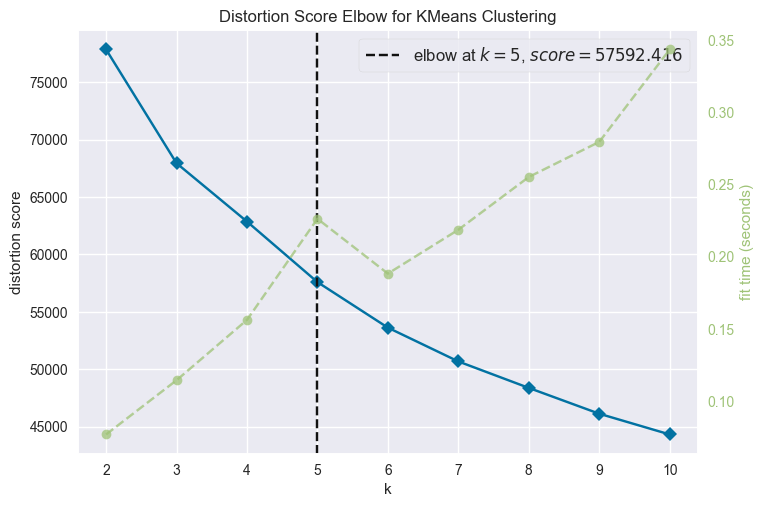

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [247]:
# 确定应该形成的聚类数目
Elbow_M = KElbowVisualizer(KMeans(), k=10)

Elbow_M.fit(customer_cluster2)
Elbow_M.show()

In [258]:
# Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=5)

# 拟合和预测，得到每个样本点的聚类标签
yhat_AC = AC.fit_predict(customer_cluster2)
customer_cluster2["Clusters"] = yhat_AC

# 将聚类标签（yhat_AC）添加到原始数据集中，以便后续分析和可视化
customer_cluster3 = customer_cluster.copy()
customer_cluster3["Clusters"]= yhat_AC

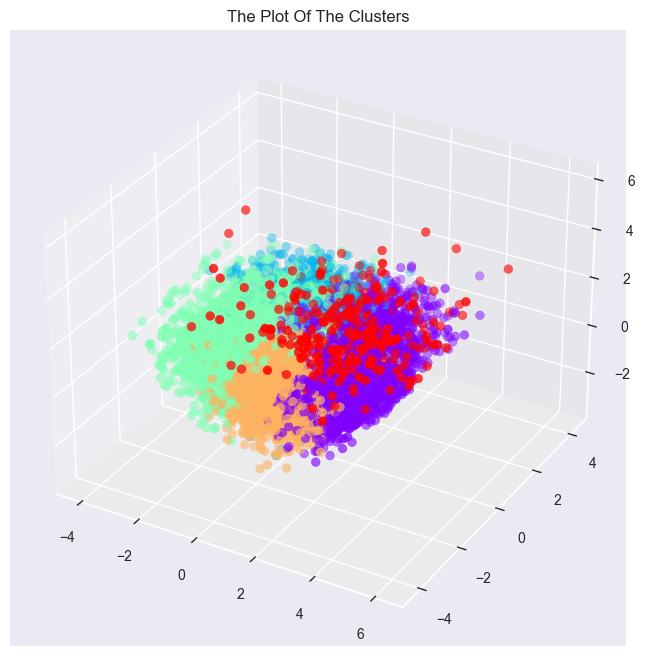

In [259]:
# 聚类可视化
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=customer_cluster3["Clusters"], marker='o', cmap = 'rainbow' )
ax.set_title("The Plot Of The Clusters")

plt.show()

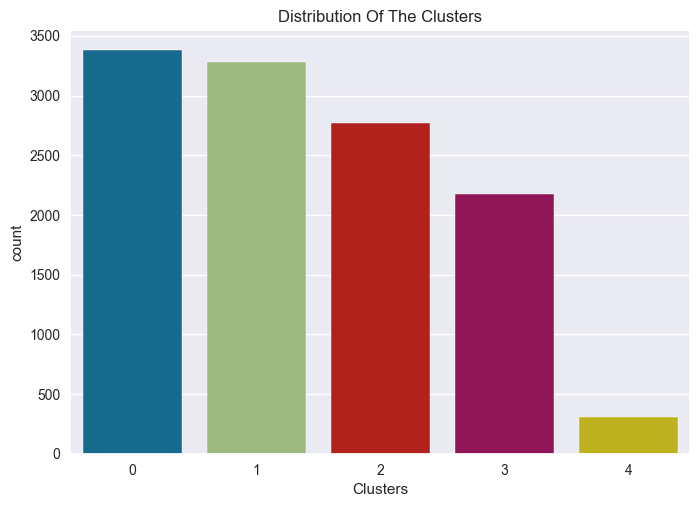

In [260]:
# 绘制聚类结果的分布情况图
pl = sns.countplot(x=customer_cluster3["Clusters"])

pl.set_title("Distribution Of The Clusters")

plt.show()

## 5.3 客户特征分析

In [261]:
customer_cluster3

,age,gender,income,num_received,num_viewed,num_completed,num_transactions,money_spent,Clusters
0,75,0,100000.0,4,4,3,7,159.27,3
1,68,1,70000.0,4,3,2,3,57.73,1
2,65,1,53000.0,6,6,5,3,36.43,0
3,58,1,51000.0,3,2,1,4,15.62,2
4,61,0,57000.0,5,5,3,6,85.55,3
...,...,...,...,...,...,...,...,...,...
11911,64,1,51000.0,5,3,3,9,32.44,1
11912,70,0,39000.0,5,5,4,15,143.75,0
11913,61,1,72000.0,3,1,1,7,25.97,2
11914,83,0,50000.0,3,3,3,14,189.67,2


In [262]:
customer_cluster3.columns

Index(['age', 'gender', 'income', 'num_received', 'num_viewed',
       'num_completed', 'num_transactions', 'money_spent', 'Clusters'],
      dtype='object')

<Figure size 800x550 with 0 Axes>

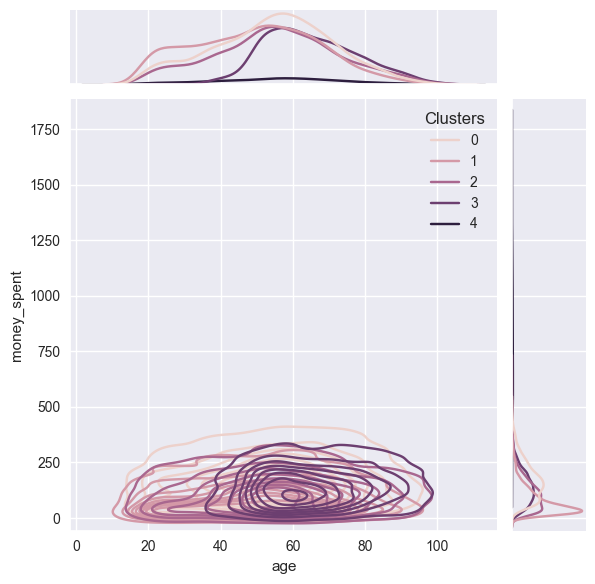

<Figure size 800x550 with 0 Axes>

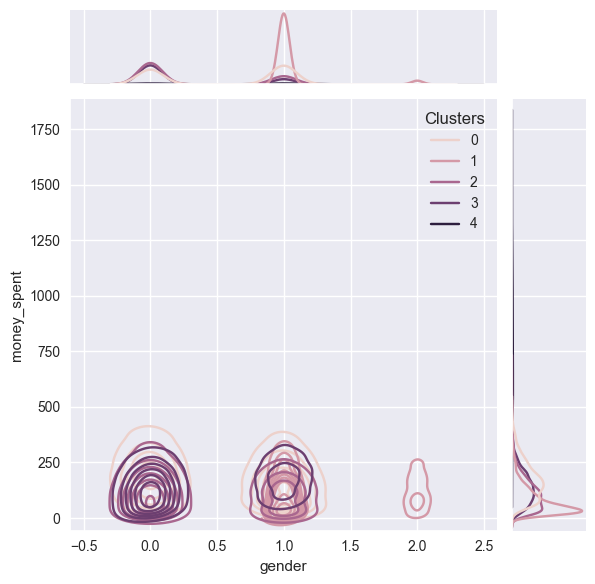

<Figure size 800x550 with 0 Axes>

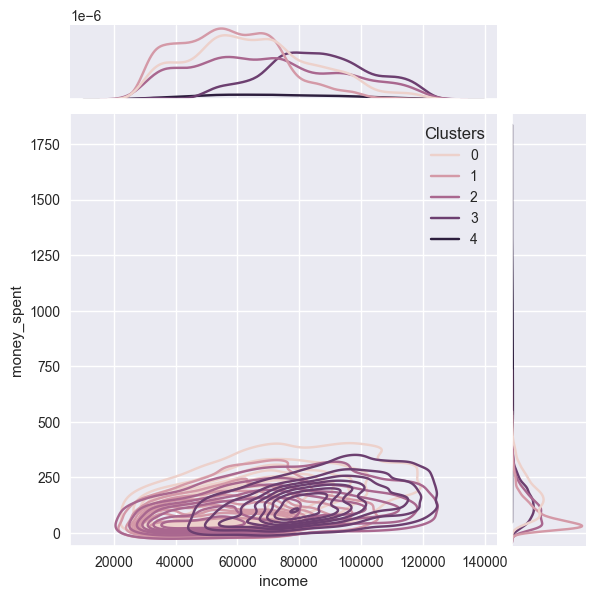

<Figure size 800x550 with 0 Axes>

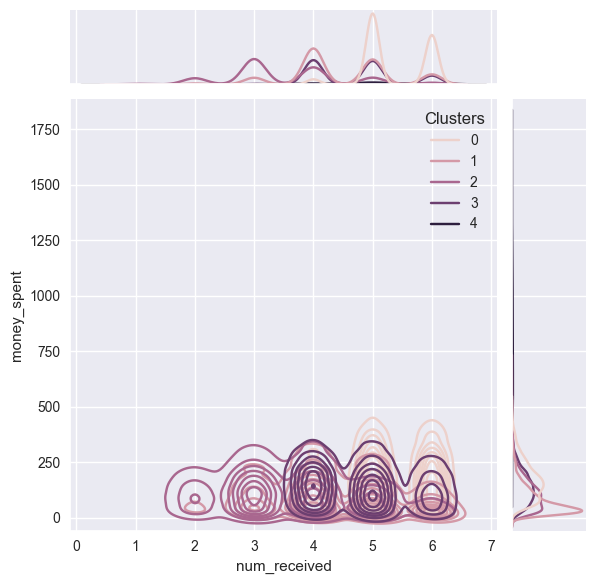

<Figure size 800x550 with 0 Axes>

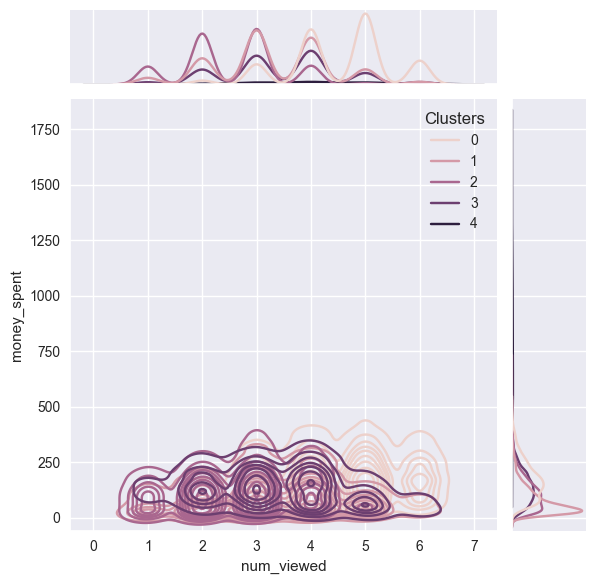

<Figure size 800x550 with 0 Axes>

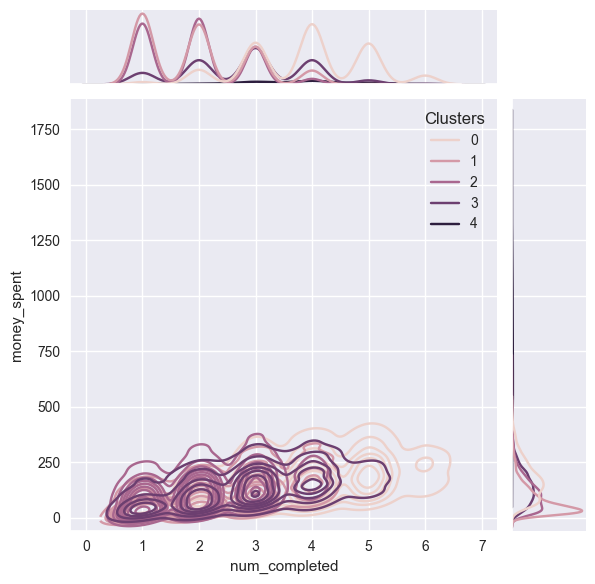

<Figure size 800x550 with 0 Axes>

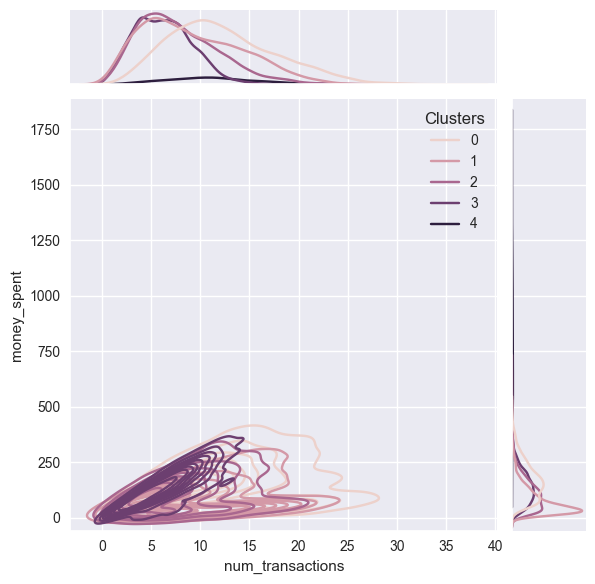

In [268]:
Personal = [ 'age', 'gender', 'income', 'num_received', 'num_viewed', 'num_completed', 'num_transactions']

for i in Personal:
    plt.figure()
    sns.jointplot(x=customer_cluster3[i], y=customer_cluster3["money_spent"], hue =customer_cluster3["Clusters"], kind="kde")
    plt.show()